# Extracting intertidal extent and elevation <img align="right" src="../Supplementary_data/dea_logo.jpg">

* **Compatability:** Notebook currently compatible with both the `NCI` and `DEA Sandbox` environments
* **Products used:** `'item_v2'`, `nidem`


## Description
Analysis run to provide data for Queensland Department of Environment and Science
***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

In [1]:
import sys
import datacube
import numpy as np
import xarray as xr
import geopandas as gpd
from datacube.utils import geometry
from datacube.utils.cog import write_cog

from dea_tools.spatial import xr_vectorize, xr_rasterize, subpixel_contours
from dea_tools.plotting import map_shapefile


/env/lib/python3.6/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.7.2-CAPI-1.11.0 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


### Connect to the datacube

Connect to the datacube so we can access DEA data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [2]:
dc = datacube.Datacube(app='Intertidal_extents_elevation')

### Analysis parameters

* `boundary_shp`: Path to the shapefile containing boundaries for the Ramsar site


In [3]:
boundary_shp = 'mia_toondah/mia_toondah_boundary.shp'
out_name = 'mia_toondah'

## Load data
### Load extent

In [4]:
boundary_gdf = gpd.read_file(boundary_shp).to_crs('EPSG:3577')
geom = geometry.Geometry(geom=boundary_gdf.iloc[0].geometry, 
                         crs=boundary_gdf.crs)

map_shapefile(boundary_gdf, attribute='id')

Label(value='')

Map(center=[-27.533487561478992, 153.30090715552933], controls=(ZoomControl(options=['position', 'zoom_in_text…

### Load intertidal data

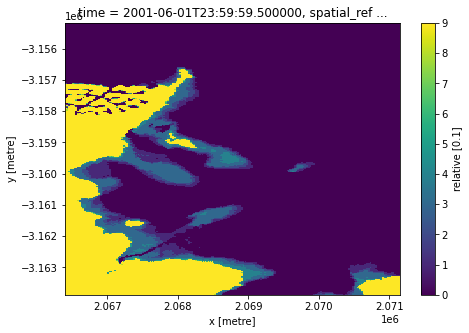

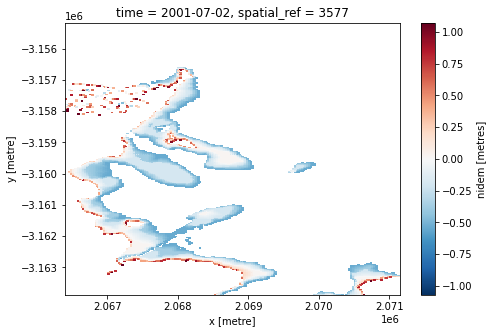

In [5]:
# Load data
item = dc.load(product='item_v2',
               geopolygon=geom).relative.squeeze(dim='time')
nidem = dc.load(product='nidem',
                geopolygon=geom).nidem.squeeze(dim='time')

# Set nodata to NaN
item = item.where(item != -6666)
nidem = nidem.where(nidem != -9999)

# Plot
item.plot(size=5)
nidem.plot(size=5)

## Extract intertidal extent as polygon

In [17]:
intertidal_pixels = (item > 0) & (item < 9)
intertidal_polygons_all = xr_vectorize(intertidal_pixels, 
                                       crs=nidem.crs, 
                                       mask=intertidal_pixels.values)
intertidal_polygons = gpd.clip(intertidal_polygons_all, boundary_gdf)
intertidal_polygons['area_km2'] = intertidal_polygons.geometry.area / (1000 * 1000)
intertidal_polygons.to_file(f'{out_name}/{out_name}_intertidalextent.shp')

/env/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


## Extract rasters

In [18]:
boundary_da = xr_rasterize(boundary_gdf, da=item)
item_mia = item.where(boundary_da)
nidem_mia = nidem.where(boundary_da)

In [19]:
write_cog(geo_im=item_mia, 
          fname=f'{out_name}/{out_name}_intertidalextents.tif', 
          overwrite=True)
write_cog(geo_im=nidem_mia, 
          fname=f'{out_name}/{out_name}_intertidalelevation.tif', 
          overwrite=True)

PosixPath('mia_toondah/mia_toondah_intertidalelevation.tif')

## Zip

In [20]:
import shutil
shutil.make_archive(out_name, 'zip', out_name)

'/home/jovyan/dev/dea-notebooks/DES_Ramsar/mia_toondah.zip'

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** April 2021

**Compatible datacube version:** 

In [10]:
print(datacube.__version__)

1.8.4.dev63+g6ee0462c
